In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.utils as utils
import matplotlib.pyplot as plt
import import_ipynb
from calculate_fid import calculate_fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Generator(nn.Module):
    def __init__(self, classes, embed_size, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(classes, embed_size)

        self.init_layer = nn.Sequential(
            nn.ConvTranspose2d(noise_channels + embed_size, features * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features * 16),
            nn.ReLU(True)
        )
        self.inner_layer1 = nn.Sequential(
            nn.ConvTranspose2d(features * 16, features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True)
        )
        self.inner_layer2 = nn.Sequential(
            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True)
        )
        self.inner_layer3 = nn.Sequential(
            nn.ConvTranspose2d(features * 4, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True)
        )
        self.out_layer = nn.Sequential(
            nn.ConvTranspose2d(features * 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.embed(labels).view(-1, self.embed.embedding_dim, 1, 1)
        label_embed = label_embed.expand(-1, -1, noise.size(2), noise.size(3))  # Match noise dimensions

        x = torch.cat([noise, label_embed], dim=1)
        x = self.init_layer(x)
        x = self.inner_layer1(x)
        x = self.inner_layer2(x)
        x = self.inner_layer3(x)
        return self.out_layer(x)

gen = Generator(10, 100, 100, 3, 64).to(device) #embedsize same as noise channels

In [3]:
class Discriminator(nn.Module):
    def __init__(self, classes, img_size, img_channels, feature_maps):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(classes, img_size * img_size)
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.real_fake_layer = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

        self.class_label = nn.Sequential(
            nn.Conv2d(512, classes + 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, images):
        images = self.conv_layers(images)
        real_fake = self.real_fake_layer(images).view(-1)  # Flatten for output
        class_labels = self.class_label(images).view(-1, 11)  # Flatten for output
        return real_fake, class_labels

dis = Discriminator(10, 64, 3, 64).to(device)

In [4]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

gen.apply(initialize_weights)
dis.apply(initialize_weights)

optim_gen = torch.optim.Adam(gen.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr = 0.0002, betas=(0.5, 0.999))

#Define 2 loss functions
loss_adversarial = nn.BCELoss()
loss_auxiliary = nn.NLLLoss()

gen.train()

Generator(
  (embed): Embedding(10, 100)
  (init_layer): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inner_layer1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inner_layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inner_layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [5]:
dis.train()

Discriminator(
  (label_embedding): Embedding(10, 4096)
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (real_fake_layer): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 

In [6]:
#Loading CIFR10 dataset
t = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), 
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifr_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=t)
cifr_loader = DataLoader(cifr_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [7]:
#Training Generator and Discriminator
    
# Initialize variables
gen_losses = []
dis_losses = []
saved_images = []
fid_scores = []
count = 0
fixed_noise = torch.randn(32, 100, 1, 1, device=device)
fixed_input = torch.randint(0, 10, (32,), device=device)

output_dir = 'output_ACGAN'
os.makedirs(output_dir, exist_ok=True)

# Start training
epoch = 0
while epoch < 40:
    for idx, (img, labels) in enumerate(cifr_loader):
        real_images = img.to(device)
        real_labels = labels.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        dis.zero_grad()
        dis_label = torch.full((batch_size,), 1.0, device=device)
        output, aux = dis(real_images)
        loss_dis_real = (
            loss_adversarial(output, dis_label) + loss_auxiliary(aux, real_labels)
        )
        loss_dis_real.backward()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = gen(noise, fake_labels)
        dis_label.fill_(0.)
        output, aux = dis(fake_images.detach())
        loss_dis_fake = (
            loss_adversarial(output, dis_label) + loss_auxiliary(aux, fake_labels)
        )
        loss_dis_fake.backward()
        optim_dis.step()
        dis_losses.append(loss_dis_real.item() + loss_dis_fake.item())
        
        #Train Generator
        gen.zero_grad()
        dis_label.fill_(1)
        output, aux = dis(fake_images)
        loss_gen = (
            loss_adversarial(output, dis_label) + loss_auxiliary(aux, fake_labels)
        )
        loss_gen.backward()
        optim_gen.step()

        gen_losses.append(loss_gen.item())

        # Save generated images at intervals
        if (idx % 500 == 0) or ((epoch == 39) and (idx == len(cifr_loader) - 1)):
            with torch.no_grad():
                fake_images = gen(fixed_noise, fixed_input).detach().cpu()
            saved_images.append(utils.make_grid(fake_images, padding=2, normalize=True))
            save_image(fake_images, f"{output_dir}/fake_samples_epoch{epoch}-{idx}.png", normalize=True)

    # Calculate FID score after each epoch
    with torch.no_grad():
        sample_epoch_images = gen(fixed_noise, fixed_input).detach()
    fid_score = calculate_fid_score(real_images.cpu(), sample_epoch_images.cpu())
    fid_scores.append(fid_score)
    fake_img = gen(noise, fake_labels)
    
    if epoch%5 == 0:
        print(f'\nEpoch [{epoch}/40] '
              f'Loss Generator: {loss_gen.item():.3f}, Loss Discriminator: {(loss_dis_real+loss_dis_fake).item()/2:.3f}, '
              f'FID Score: {fid_score:.3f}')
        
    fake_image_path = os.path.join(output_dir, f'fake_samples_epoch_{epoch:03d}.png')
    real_image_path = os.path.join(output_dir, f'real_samples_epoch_{epoch:03d}.png')
    
    utils.save_image(fake_img.detach(), fake_image_path, normalize=True)
    utils.save_image(real_images.detach(), real_image_path, normalize=True)

    epoch += 1

with open(os.path.join(output_dir, 'gen_losses.txt'), 'w') as file:
    for loss in gen_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'dis_losses.txt'), 'w') as file:
    for loss in dis_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'fid_scores.txt'), 'w') as file:
    for score in fid_scores:
        file.write(f"{score}\n")

print('Training completed successfully!')

/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [0/40] Loss Generator: 1.995, Loss Discriminator: 1.467, FID Score: 438.762

Epoch [5/40] Loss Generator: 3.023, Loss Discriminator: 0.996, FID Score: 386.724

Epoch [10/40] Loss Generator: 3.193, Loss Discriminator: 0.965, FID Score: 285.288

Epoch [15/40] Loss Generator: 3.588, Loss Discriminator: 0.521, FID Score: 256.991

Epoch [20/40] Loss Generator: 4.201, Loss Discriminator: 0.964, FID Score: 277.786

Epoch [25/40] Loss Generator: 4.749, Loss Discriminator: 0.365, FID Score: 283.330

Epoch [30/40] Loss Generator: 6.220, Loss Discriminator: 0.246, FID Score: 289.297

Epoch [35/40] Loss Generator: 4.890, Loss Discriminator: 0.314, FID Score: 306.412
Training completed successfully!


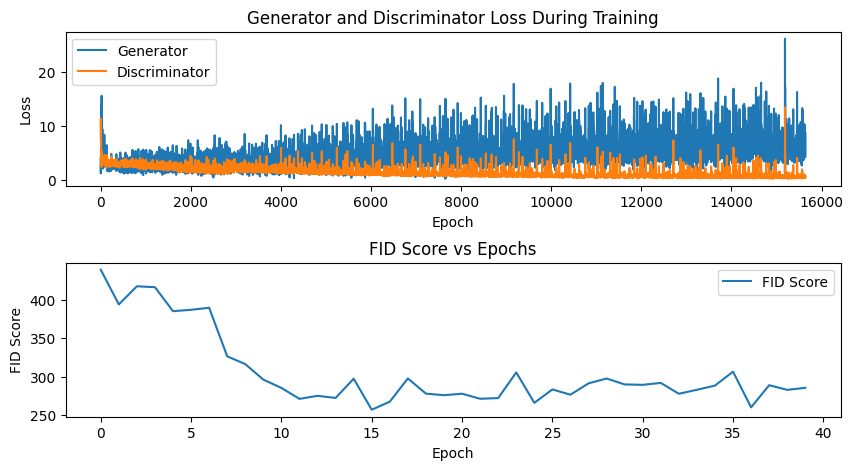

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(gen_losses, label="Generator")
plt.plot(dis_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")

plt.subplot(2, 1, 2)
plt.plot(range(40), fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.title("FID Score vs Epochs")

plt.subplots_adjust(hspace=0.5)

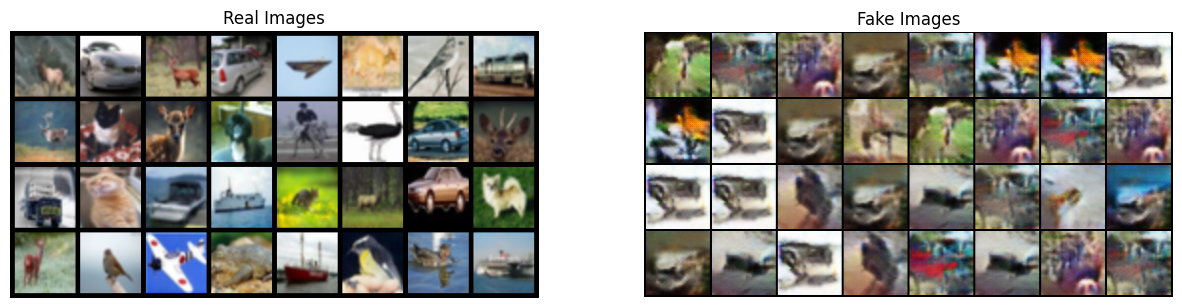

In [9]:
r_batch = next(iter(cifr_loader))

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(r_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(saved_images[-1],(1,2,0)))

plt.savefig('output_ACGAN/ACGAN_32_FAKE_IMAGES.png', format='png', bbox_inches='tight')
plt.show()